In [1]:
from imutils import face_utils
import dlib, cv2, imutils
import matplotlib.pyplot as plt
import os, sys, json
import pandas as pd
import numpy as np

import torch.utils.data as utils_data
import torch
from torch.optim import Adam
import torchvision.models as models
import torch.nn as nn

sys.path.append(os.path.abspath('../'))
from helper_functions import mag, angle

# 0. Constants

In [2]:
moods = ["anger","disgust","fear","happiness","sadness","surprise","neutral"]
mood_map = { moods[k]:k for k in range(len(moods)) } # mood : index
mood_map.update({ k:moods[k] for k in range(len(moods)) }) # index : mood

data_path = '../dataset/ck/'
model_path = '../models/FCNN_state_dicts/ck/'

# 1. Preparing the Data

### Load CSV

In [3]:
df = pd.read_csv(data_path + 'vector_coords_norm.csv')
df.head()

,filename,mood,vectors,coords
0,S010_004_00000019.png,anger,0.913848522815577 0.07291733991580246 0.825733...,0.0 0.20408163265306123 0.006622516556291391 0...
1,S011_004_00000021.png,anger,1.0 0.06939233223948903 0.9018695583426973 0.0...,0.0 0.14492753623188406 0.017964071856287425 0...
2,S014_003_00000030.png,anger,0.9226796499775556 0.07379180882521665 0.82635...,0.0 0.16428571428571428 0.0125 0.3142857142857...
3,S022_005_00000032.png,anger,1.0 0.06789987439004594 0.8821328104551961 0.0...,0.0 0.19834710743801653 0.023622047244094488 0...
4,S026_003_00000015.png,anger,1.0 0.08154931539664242 0.8700847531963809 0.0...,0.0 0.09345794392523364 0.024193548387096774 0...


### Get DataLoaders

In [4]:
def get_dataloaders(data, label, split_ratio=0.8):
    dataset_size = data.shape[0]
    train_size = int(split_ratio * dataset_size)
    test_size = dataset_size - train_size

    dataset = utils_data.TensorDataset(torch.Tensor(data), torch.LongTensor(label))
    train_set, test_set = utils_data.random_split(dataset, [train_size, test_size])
    batch_size = 64
    train_loader = utils_data.DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True)
    test_loader = utils_data.DataLoader(dataset=test_set, batch_size=batch_size, shuffle=True)
    print('Data is ready!')
    
    return train_loader, test_loader

In [5]:
%%time
num_samples = df.shape[0]

vectors, coords = [], []
for index, row in df.iterrows():
    vectors.append([float(k) for k in row['vectors'].split(' ')])
    coords.append([float(k) for k in row['coords'].split(' ')])
vectors, coords = np.array(vectors), np.array(coords)

Vector = np.dstack((vectors, coords)).reshape(num_samples, -1) # shape=(samples, vectors+coords)
# Label = df.mood
Label = np.array([mood_map[k] for k in df.mood])
print(Vector.shape, Label.shape)

train_loader, test_loader = get_dataloaders(Vector, Label)

(902, 272) (902,)
Data is ready!
CPU times: total: 125 ms
Wall time: 121 ms


# 2. Build Model

In [22]:
class FCNNModel(nn.Module):
    def __init__(self, input_layer_size, hidden_layer_size, num_classes):
        super(FCNNModel, self).__init__()
        
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(input_layer_size, hidden_layer_size),
            nn.ReLU(),
            nn.Linear(hidden_layer_size, hidden_layer_size),
            nn.ReLU(),
#             nn.Linear(hidden_layer_size, hidden_layer_size),
#             nn.ReLU(),
#             nn.Linear(hidden_layer_size, hidden_layer_size),
#             nn.ReLU(),
            nn.Linear(hidden_layer_size, num_classes),
        )
    
    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

# 3. Training & Evaluation

In [7]:
def evaluate(model, cuda=True): 
    if cuda and torch.cuda.is_available():
        model = model.cuda()

    loss_func = nn.CrossEntropyLoss()  
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)      

    model.eval()
    test_acc, test_loss = 0.0, 0.0
    for step, (test_image, test_label) in enumerate(test_loader):
        if cuda and torch.cuda.is_available():
            test_image, test_label = test_image.cuda(), test_label.cuda()                
        test_output = model(test_image)
        _, predicted = torch.max(test_output.data, dim=1)
        test_acc += (predicted == test_label).sum().item()

        batch_loss = loss_func(test_output, test_label)
        test_loss += batch_loss.item()

    test_acc /= len(test_loader.dataset)
    test_loss /= (step+1)

    return {'test_loss': test_loss, 'test_acc': test_acc}

def train(model, cuda=True, epochs=20, print_epoch=50, best_acc=0):

    history = []
    best_state = model.state_dict()

    if cuda and torch.cuda.is_available():
        model = model.cuda()

    loss_func = nn.CrossEntropyLoss()  
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)      
    
    train_accs, test_accs = [], []
    for epoch in range(epochs):
        # Training Phase
        train_acc, train_loss = 0.0, 0.0
        for step, (batch_image, batch_label) in enumerate(train_loader):
            model.train()
            if cuda and torch.cuda.is_available():
                batch_image, batch_label = batch_image.cuda(), batch_label.cuda()
            batch_output = model(batch_image)
            batch_loss = loss_func(batch_output, batch_label)

            optimizer.zero_grad()
            batch_loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            train_loss += batch_loss.item()
            _, train_predicted = torch.max(batch_output.data, 1)
            train_acc += (train_predicted == batch_label).sum().item()

        # Validation Phase
        result = evaluate(model, cuda)
        result['train_loss'] = train_loss / (step+1)
        result['train_acc'] = train_acc / len(train_loader.dataset)
        history.append(result)  

        if (not ((epoch+1) % print_epoch)) or ((epoch+1) == epochs):
            print('epoch=%d' % (epoch+1) + (' ' if (epoch+1)<10 else ''), end='')
            print('\ttrain loss=%.5f\ttest loss=%.5f\ttrain accuracy=%.3f\ttest accuracy=%.3f' %
                (result['train_loss'], result['test_loss'], result['train_acc'], result['test_acc']))

        if result['test_acc'] > best_acc:
            best_state = model.state_dict()
            best_acc = result['test_acc']
    
    return history, best_state

In [ ]:
# Create new model
fcnn = FCNNModel(Vector.shape[1], 128, 7) # input, hidden, output
history = [evaluate(fcnn)]
print(history)

[{'test_loss': 1.967277838065561, 'test_acc': 0.05572582892170521}]


In [ ]:
# Load new model
state = torch.load(model_path + 'FCNN.pt', map_location='cpu')
fcnn.load_state_dict(state['state_dict'])
history = state['history']
print(len(history))

100


In [ ]:
%%time
history_one_cycle, best_state = train(fcnn, cuda=True, epochs=100, print_epoch=10, best_acc=max([x['test_acc'] for x in history]))
history = ([] if len(history)==1 else history) + history_one_cycle

epoch=0 	train loss=1.30586	test loss=1.35548	train accuracy=0.497	test accuracy=0.482
epoch=10	train loss=1.30656	test loss=1.37989	train accuracy=0.501	test accuracy=0.480
epoch=20	train loss=1.29398	test loss=1.35261	train accuracy=0.503	test accuracy=0.479
epoch=30	train loss=1.28389	test loss=1.33933	train accuracy=0.507	test accuracy=0.494
epoch=40	train loss=1.28507	test loss=1.35935	train accuracy=0.507	test accuracy=0.486
epoch=50	train loss=1.27980	test loss=1.36667	train accuracy=0.509	test accuracy=0.485
epoch=60	train loss=1.27166	test loss=1.34498	train accuracy=0.513	test accuracy=0.488
epoch=70	train loss=1.26401	test loss=1.36220	train accuracy=0.515	test accuracy=0.485
epoch=80	train loss=1.25867	test loss=1.34617	train accuracy=0.521	test accuracy=0.484
epoch=90	train loss=1.25371	test loss=1.36014	train accuracy=0.522	test accuracy=0.483
epoch=99	train loss=1.24970	test loss=1.35446	train accuracy=0.521	test accuracy=0.486
CPU times: user 4min 37s, sys: 449 ms, tota

# 4. Plotting Performance Graphs of the Model

In [8]:
def plot_accuracies(history):
    train_accs = [x['train_acc'] for x in history]
    val_accs = [x['test_acc'] for x in history]
    plt.plot(train_accs, label='Train accuracy')
    plt.plot(val_accs, label='Val accuracy')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend()
    plt.title('Accuracy vs. No. of epochs');

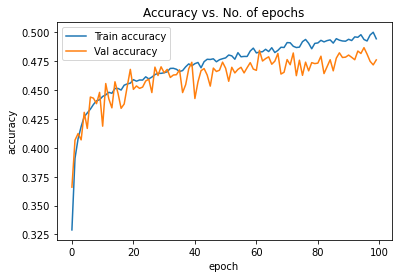

In [ ]:
plot_accuracies(history)

In [9]:
def plot_losses(history):
    train_losses = [x['train_loss'] for x in history]
    val_losses = [x['test_loss'] for x in history]
    plt.plot(train_losses, label='Train loss')
    plt.plot(val_losses, label='Val loss')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend()
    plt.title('Loss vs. No. of epochs');

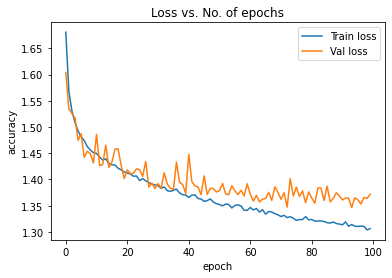

In [ ]:
plot_losses(history)

# 5. Save Model

In [ ]:
path = '/content/drive/MyDrive/Colab Notebooks/EE4705/'
state = {
    'history': history,
    'state_dict': best_state
}
torch.save(state, model_path + 'FCNN.pt')

# 6. Tuning Hidden Layer Size

In [10]:
hidden_layer_sizes = [16, 32, 64, 128, 256, 512]

### Create/Load Models

In [24]:
models, histories = [], []
for hidden_layer_size in hidden_layer_sizes:
    model = FCNNModel(Vector.shape[1], hidden_layer_size, 7) # input, hidden, output
    models.append(model)
    histories.append([evaluate(model)])

In [26]:
for i in range(len(hidden_layer_sizes)):
    hidden_layer_size = hidden_layer_sizes[i]
    state = torch.load(model_path + 'FCNN_norm_%d.pt' % hidden_layer_size)
    models[i].load_state_dict(state['state_dict'])
    histories[i] = state['history']

### Training & Evaluation

In [12]:
%%time
best_states = []
for i in range(len(models)):
    print('Hidden layer size: %d' % hidden_layer_sizes[i])
    history = histories[i]
    history_one_cycle, best_state = train(models[i], cuda=True, epochs=200, print_epoch=20, best_acc=max([x['test_acc'] for x in history]))
    histories[i] = ([] if len(history)==1 else history) + history_one_cycle
    best_states.append(best_state)
    print()

Hidden layer size: 16
epoch=20	train loss=1.18919	test loss=1.25421	train accuracy=0.662	test accuracy=0.641
epoch=40	train loss=1.20883	test loss=1.25744	train accuracy=0.662	test accuracy=0.641
epoch=60	train loss=1.01862	test loss=1.05840	train accuracy=0.725	test accuracy=0.702
epoch=80	train loss=0.82555	test loss=0.84521	train accuracy=0.761	test accuracy=0.729
epoch=100	train loss=0.76094	test loss=0.77435	train accuracy=0.785	test accuracy=0.757
epoch=120	train loss=0.74155	test loss=0.78022	train accuracy=0.778	test accuracy=0.768
epoch=140	train loss=0.71759	test loss=0.75366	train accuracy=0.788	test accuracy=0.779
epoch=160	train loss=0.76473	test loss=0.83563	train accuracy=0.775	test accuracy=0.757
epoch=180	train loss=0.69384	test loss=0.73207	train accuracy=0.784	test accuracy=0.779
epoch=200	train loss=0.68928	test loss=0.70539	train accuracy=0.791	test accuracy=0.762

Hidden layer size: 32
epoch=20	train loss=1.18090	test loss=1.24540	train accuracy=0.662	test accurac

### Visualizing Performance

In [13]:
eval_dict = {
    'hidden layer size': hidden_layer_sizes,
    'train accuracy': [max([x['train_acc'] for x in k]) for k in histories],
    'test accuracy': [max([x['test_acc'] for x in k]) for k in histories],
}
eval_df = pd.DataFrame(eval_dict)
eval_df.set_index('hidden layer size', inplace=True)
display(eval_df)

,train accuracy,test accuracy
hidden layer size,,
16,0.796117,0.784530
32,0.809986,0.795580
64,0.812760,0.801105
128,0.891817,0.889503
256,0.897365,0.900552
512,0.901526,0.895028


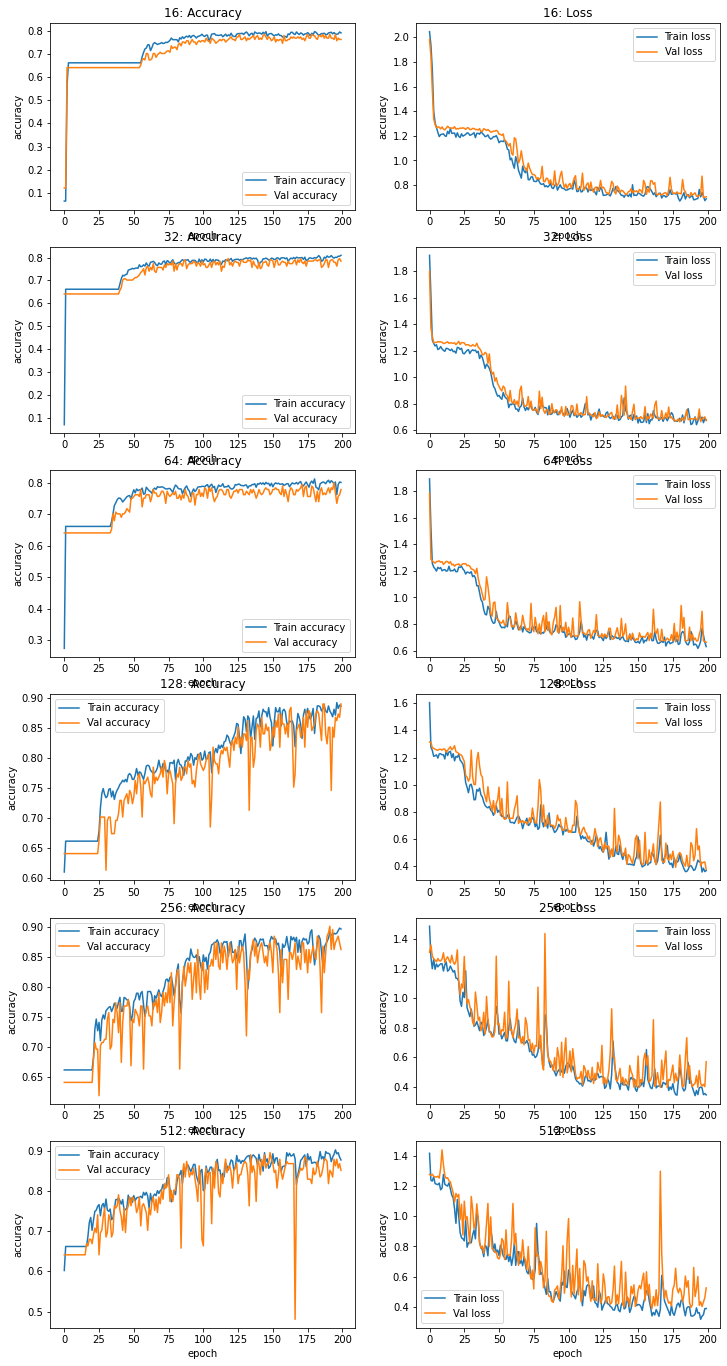

In [14]:
fig = plt.figure(figsize=(12,24))
rows, cols = len(hidden_layer_sizes), 2
for i in range(len(hidden_layer_sizes)):
    history = histories[i]
    fig.add_subplot(rows, cols, i*2+1)
    plot_accuracies(history)
    plt.title('%d: Accuracy' % hidden_layer_sizes[i])
    fig.add_subplot(rows, cols, i*2+2)
    plot_losses(history)
    plt.title('%d: Loss' % hidden_layer_sizes[i])

### Save Models

In [15]:
for i in range(len(hidden_layer_sizes)):
    state = {
        'history': histories[i],
        'state_dict': best_states[i]
    }
    torch.save(state, model_path + 'FCNN_5layers_%d.pt' % hidden_layer_sizes[i])

# 5. Testing Models

In [29]:
import random
import math

In [32]:
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('../shape_predictor_68_face_landmarks.dat')

In [ ]:
# get all image filenames
image_filenames = []
for root, dirs, files in os.walk(data_path):
    dirc = os.path.basename(root)
    if dirc != "contempt":
        for file in files:
            image_filenames += [data_path + dirc + '/' + file]        

In [ ]:
# load models
fcnn_model = torch.load('./trained_models/FCNN_model.pt')
fcnn_model.eval()
cnn_model = cnn_models['CNNModel1'].model
cnn_model.eval()

CNNModel(
  (conv1): Sequential(
    (0): Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0, inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0, inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ELU(alpha=1.0, inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stat

A: neutral, P(FCNN): neutral, P(CNN): fear


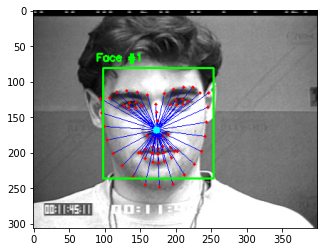

A: neutral, P(FCNN): neutral, P(CNN): fear


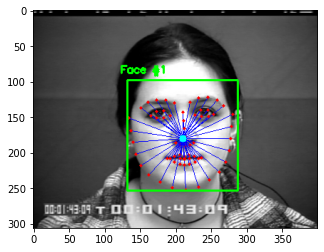

A: happiness, P(FCNN): happiness, P(CNN): fear


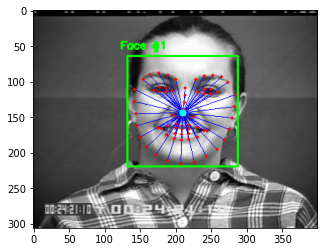

A: neutral, P(FCNN): neutral, P(CNN): fear


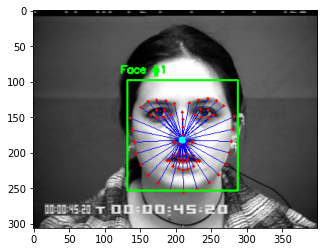

A: fear, P(FCNN): fear, P(CNN): fear


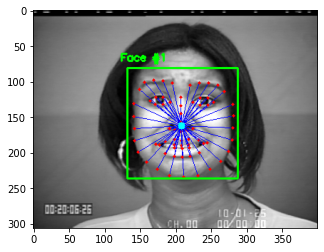

A: happiness, P(FCNN): happiness, P(CNN): fear


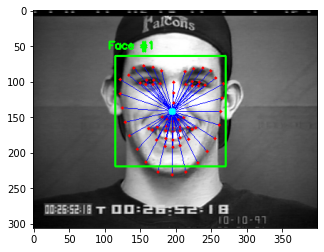

A: neutral, P(FCNN): neutral, P(CNN): fear


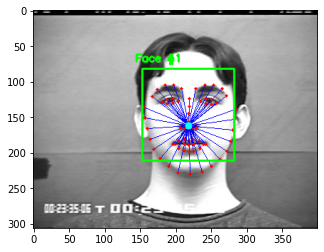

A: happiness, P(FCNN): happiness, P(CNN): fear


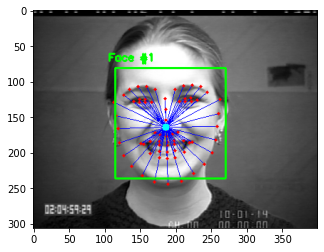

A: anger, P(FCNN): anger, P(CNN): fear


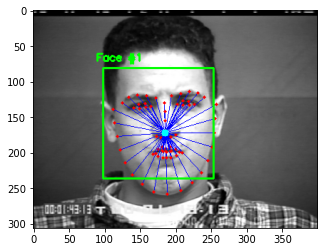

A: neutral, P(FCNN): neutral, P(CNN): fear


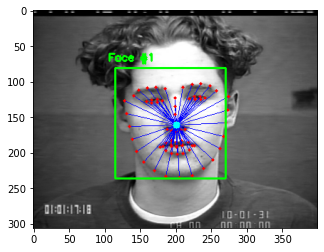

In [ ]:
rand_images = random.sample(image_filenames, 10) # get random images  

for path in rand_images:   
    vectors, coords = [], []

    image = cv2.imread(path)
    image = imutils.resize(image, width=400)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.equalizeHist(gray)
    
    rect = detector(gray, 1)[0]
    shape = predictor(gray, rect)
    shape = face_utils.shape_to_np(shape)        

    cog = tuple(shape.mean(axis=0).astype(int)) # get center of gravity (COG)            
    for (x,y) in shape:
        vectors.append([mag(cog, (x,y)), angle(cog, (x,y))]) # get vector magnitude and direction                
        coords.append([x,y]) # append coordinates relative to cog

    ## vector input
    vectors = np.array(vectors)        
    scale_factor = 1 / max(vectors[:,0])
    vectors[:,0] = vectors[:,0] * scale_factor # normalize magnitudes
    coords = np.array(coords) * scale_factor
    coords = coords.reshape(-1)
    
    ## graylevel input
    dim = 50
    cnn_input = image[y:y+h, x:x+w] # crop to face
    cnn_input = cv2.cvtColor(cnn_input, cv2.COLOR_RGB2GRAY) # convert to grayscale
    cnn_input = cv2.equalizeHist(cnn_input) # equalize histogram
    cnn_input = imutils.resize(cnn_input, width=int(dim*1.05)) # buffer of 5 pixels for cropping to 100x100
    cnn_input = cnn_input[:dim,:dim]
    cnn_input = cnn_input.reshape(1,1,dim,dim) # shape=(1,1,dim,dim)
    
    # prediction
    fcnn_input = np.dstack((vectors.reshape(1, -1), coords)).reshape(1, -1) # shape=(1, 272)
    with torch.no_grad():
        fcnn_pred_tensor = fcnn_model(torch.Tensor(fcnn_input).cuda()).argmax()
        fcnn_pred = fcnn_pred_tensor.cpu().numpy().item()
        cnn_pred_tensor = cnn_model(torch.Tensor(cnn_input).cuda()).argmax()
        cnn_pred = cnn_pred_tensor.cpu().numpy().item()        
    fcnn_pred_label = mood_map[fcnn_pred]
    cnn_pred_label = mood_map[cnn_pred]

    true_label = path.split('/')[2]
    print("A: %s, P(FCNN): %s, P(CNN): %s" % (true_label, fcnn_pred_label, cnn_pred_label))
    plt.imshow(image) # adapted for jupyter
    plt.show()